# Importing all the required libraries

In [103]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from warnings import filterwarnings
filterwarnings('ignore')

#for imputing the outlier values
from sklearn.impute import KNNImputer

from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF

# for scaling 
from sklearn.preprocessing import RobustScaler 

#for anomaly detection
from pycaret.anomaly import *

#for visualization
import dtale
from autoviz.AutoViz_Class import AutoViz_Class
from scipy import stats

from sklearn.model_selection import train_test_split,cross_val_score,KFold
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,classification_report,roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier,StackingClassifier,AdaBoostClassifier
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

# Reading the data Set

In [4]:
#reading the raw data set into df called 'data'
data = pd.read_csv('data.csv')

In [5]:
pd.DataFrame(data.columns)

0
0                                                  Bankrupt?
1    ROA(C) before interest and depreciation before interest
2                     ROA(A) before interest and % after tax
3          ROA(B) before interest and depreciation after tax
4                                     Operating Gross Margin
5                                Realized Sales Gross Margin
6                                      Operating Profit Rate
7                                  Pre-tax net Interest Rate
8                                After-tax net Interest Rate
9                Non-industry income and expenditure/revenue
10                      Continuous interest rate (after tax)
11                                    Operating Expense Rate
12                     Research and development expense rate
13                                            Cash flow rate
14                       Interest-bearing debt interest rate
15                                              Tax rate (A)
16                                   Net Value Per Share (B)
17                                   Net Value Per Share (A)
18                                   Net Value Per Share (C)
19                   Persistent EPS in the Last Four Seasons
20                                       Cash Flow Per Share
21                                Revenue Per Share (Yuan ¥)
22                       Operating Profit Per Share (Yuan ¥)
23                  Per Share Net profit before tax (Yuan ¥)
24                   Realized Sales Gross Profit Growth Rate
25                              Operating Profit Growth Rate
26                          After-tax Net Profit Growth Rate
27                            Regular Net Profit Growth Rate
28                         Continuous Net Profit Growth Rate
29                                   Total Asset Growth Rate
30                                     Net Value Growth Rate
31                      Total Asset Return Growth Rate Ratio
32                                       Cash Reinvestment %
33                                             Current Ratio
34                                               Quick Ratio
35                                    Interest Expense Ratio
36                                Total debt/Total net worth
37                                              Debt ratio %
38                                          Net worth/Assets
39                      Long-term fund suitability ratio (A)
40                                      Borrowing dependency
41                          Contingent liabilities/Net worth
42                          Operating profit/Paid-in capital
43                     Net profit before tax/Paid-in capital
44               Inventory and accounts receivable/Net value
45                                      Total Asset Turnover
46                              Accounts Receivable Turnover
47                                   Average Collection Days
48                           Inventory Turnover Rate (times)
49                           Fixed Assets Turnover Frequency
50                           Net Worth Turnover Rate (times)
51                                        Revenue per person
52                               Operating profit per person
53                                Allocation rate per person
54                           Working Capital to Total Assets
55                                 Quick Assets/Total Assets
56                               Current Assets/Total Assets
57                                         Cash/Total Assets
58                            Quick Assets/Current Liability
59                                    Cash/Current Liability
60                               Current Liability to Assets
61                              Operating Funds to Liability
62                                 Inventory/Working Capital
63                               Inventory/Current Liability
64                             Current Liabilities/Liability
65                               

In [6]:
data_col = pd.DataFrame(columns=['Features'])

In [7]:
#making the copy of original data
data_copy = data.copy()
data_copy1 = data_copy.copy()

# Treatment of Outliers

In [8]:
# Custom function for calculating the number of outliers for each column 
#which are outside of standard IQR range (between 25th & 75th percentie)

def cal_num_outliers(data,col,q1,q3):
    Q1 = data[col].quantile(q1)
    Q3 = data[col].quantile(q3)
    IQR = Q3 - Q1
    data_outliers = data[(data[col] < Q1 - 1.5*IQR) | (data[col] > Q3 + 1.5*IQR)]
    return data_outliers.shape[0]
    

In [9]:
#Custom function for calculating the number of outliers for each column which are outside of q1 & q3 range

def cal_num_outliers1(data,col,q1,q3):
    Q_low = data[col].quantile(q1)
    Q_upper = data[col].quantile(q3)
    #IQR = Q3 - Q1
    data_outliers = data[(data[col] < Q_low) | (data[col] > Q_upper)][col]
    return data_outliers.shape[0]
    

In [10]:
#defining three empty lists(for calculating total number of outliers in each column for three Quartile ranges) 
#and appending the count of outliers retrieved from custom functions

lst_25_75 = []
lst_05_95 = []
lst_01_99 = []
for i in data.columns:
    lst_25_75.append(cal_num_outliers(data,i,0.25,0.75))
    lst_05_95.append(cal_num_outliers1(data,i,0.05,0.95))
    lst_01_99.append(cal_num_outliers1(data,i,0.01,0.99))

In [11]:
#defining a comparision data frame and placing the the total num of outlier values for each 'Feature'

df_comp = pd.DataFrame()
df_comp['No of Outliers for 0.25 & 0.75'] = lst_25_75
df_comp['No of Outliers for 0.05 & 0.95'] = lst_05_95
df_comp['No of Outliers for 0.01 & 0.99'] = lst_01_99
df_comp['Features'] = data.columns
df_comp.set_index('Features',inplace= True)

In [12]:
#displaying the comparision data frame
df_comp

No of Outliers for 0.25 & 0.75  \
Features                                                                                   
Bankrupt?                                                                            220   
 ROA(C) before interest and depreciation before interest                             391   
 ROA(A) before interest and % after tax                                              561   
 ROA(B) before interest and depreciation after tax                                   432   
 Operating Gross Margin                                                              320   
 Realized Sales Gross Margin                                                         318   
 Operating Profit Rate                                                               716   
 Pre-tax net Interest Rate                                                           773   
 After-tax net Interest Rate                                                         867   
 Non-industry income and expenditure/revenue                                        1094   
 Continuous interest rate (after tax)                                                806   
 Operating Expense Rate                                                                0   
 Research and development expense rate                                               182   
 Cash flow rate                                                                      576   
 Interest-bearing debt interest rate                                                 396   
 Tax rate (A)                                                                        120   
 Net Value Per Share (B)                                                             457   
 Net Value Per Share (A)                                                             464   
 Net Value Per Share (C)                                                             465   
 Persistent EPS in the Last Four Seasons                                             508   
 Cash Flow Per Share                                                                 532   
 Revenue Per Share (Yuan ¥)                                                          478   
 Operating Profit Per Share (Yuan ¥)                                                 442   
 Per Share Net profit before tax (Yuan ¥)                                            511   
 Realized Sales Gross Profit Growth Rate                                             814   
 Operating Profit Growth Rate                                                       1008   
 After-tax Net Profit Growth Rate                                                   1033   
 Regular Net Profit Growth Rate                                                     1030   
 Continuous Net Profit Growth Rate                                                  1042   
 Total Asset Growth Rate                                                            1381   
 Net Value Growth Rate                                                               792   
 Total Asset Return Growth Rate Ratio                                                674   
 Cash Reinvestment %                                                                 617   
 Current Ratio                                                                       589   
 Quick Ratio                                                                         591   
 Interest Expense Ratio                                                             1362   
 Total debt/Total net worth                                                          407   
 Debt ratio %                                                                         30   
 Net worth/Assets                                                                     30   
 Long-term fund suitability ratio (A)                                                810   
 Borrowing dependency                                                                321   
 Contingent liabilities/Net worth                                                    942   
 Operating

In [16]:
#removing the outliers
#while removing the outliers missing values get introduced
#so these missing values are actually the outlier values

data_without_outliers = data[~((data < data.quantile(0.01)) | (data > data.quantile(0.99)))]

In [17]:
#we are considering to drop the row(index), if it has 11 outier values (here it is missing values) 
#we can use thresh parameter in drop na
#thresh states, min number of values in the row without missing values to be considered not to drop the row

data_thresh_10 = data_without_outliers.dropna(thresh = data_without_outliers.shape[1] - 10)
data_thresh_10.shape

(6525, 96)

In [18]:
imputer = KNNImputer()
x = imputer.fit_transform(data_thresh_10)
x.shape

(6525, 96)

In [19]:
data_cleaned = pd.DataFrame(data = x,columns=data_thresh_10.columns)

In [20]:
data_cleaned.shape

(6525, 96)

# Checking for Missing Values

In [21]:
data_cleaned.isna().sum()

Bankrupt?                                                   0
 ROA(C) before interest and depreciation before interest    0
 ROA(A) before interest and % after tax                     0
 ROA(B) before interest and depreciation after tax          0
 Operating Gross Margin                                     0
 Realized Sales Gross Margin                                0
 Operating Profit Rate                                      0
 Pre-tax net Interest Rate                                  0
 After-tax net Interest Rate                                0
 Non-industry income and expenditure/revenue                0
 Continuous interest rate (after tax)                       0
 Operating Expense Rate                                     0
 Research and development expense rate                      0
 Cash flow rate                                             0
 Interest-bearing debt interest rate                        0
 Tax rate (A)                                               0
 Net Val

# Checking for Derived Variables

In [33]:
#no derived variables are found --> from studying the data

# Checking for Duplicates along rows

In [22]:
data_cleaned[data_cleaned.duplicated() == True].shape

(0, 96)

In [35]:
#found no duplicates along rows


# Checking Correlation

In [23]:
#checking for co-relation
df_corr = data_cleaned.corr()
df_corr

Bankrupt?  \
Bankrupt?                                                  1.000000   
 ROA(C) before interest and depreciation before interest  -0.191894   
 ROA(A) before interest and % after tax                   -0.198699   
 ROA(B) before interest and depreciation after tax        -0.199960   
 Operating Gross Margin                                   -0.110607   
 Realized Sales Gross Margin                              -0.110101   
 Operating Profit Rate                                    -0.130956   
 Pre-tax net Interest Rate                                -0.201959   
 After-tax net Interest Rate                              -0.206882   
 Non-industry income and expenditure/revenue              -0.177211   
 Continuous interest rate (after tax)                     -0.224278   
 Operating Expense Rate                                   -0.001178   
 Research and development expense rate                    -0.017912   
 Cash flow rate                                           -0.102205   
 Interest-bearing debt interest rate                      -0.013611   
 Tax rate (A)                                             -0.103269   
 Net Value Per Share (B)                                  -0.144970   
 Net Value Per Share (A)                                  -0.148789   
 Net Value Per Share (C)                                  -0.147658   
 Persistent EPS in the Last Four Seasons                  -0.194170   
 Cash Flow Per Share                                      -0.095704   
 Revenue Per Share (Yuan ¥)                               -0.053211   
 Operating Profit Per Share (Yuan ¥)                      -0.133837   
 Per Share Net profit before tax (Yuan ¥)                 -0.188473   
 Realized Sales Gross Profit Growth Rate                  -0.029441   
 Operating Profit Growth Rate                             -0.055531   
 After-tax Net Profit Growth Rate                         -0.109973   
 Regular Net Profit Growth Rate                           -0.099670   
 Continuous Net Profit Growth Rate                        -0.092974   
 Total Asset Growth Rate                                  -0.030133   
 Net Value Growth Rate                                    -0.116448   
 Total Asset Return Growth Rate Ratio                     -0.067768   
 Cash Reinvestment %                                      -0.073654   
 Current Ratio                                            -0.111728   
 Quick Ratio                                              -0.116272   
 Interest Expense Ratio                                   -0.061269   
 Total debt/Total net worth                                0.259166   
 Debt ratio %                                              0.216862   
 Net worth/Assets                                         -0.216862   
 Long-term fund suitability ratio (A)                     -0.031194   
 Borrowing dependency                                      0.286711   
 Contingent liabilities/Net worth                          0.024351   
 Operating profit/Paid-in capital                         -0.133089   
 Net profit before tax/Paid-in capital                    -0.186880   
 Inventory and accounts receivable/Net value               0.093571   
 Total Asset Turnover                                     -0.073298   
 Accounts Receivable Turnover                             -0.018873   
 Average Collection Days                                   0.039495   
 Inventory Turnover Rate (times)                          -0.001739   
 Fixed Assets Turnover Frequency                           0.086309   
 Net Worth Turnover Rate (times)                           0.008940   
 Revenue per person                                        0.012475   
 Operating profit per person                              -0.103896   
 Allocation rate per person                                0.118814   
 Working Capital to Total Assets                          -0.156043   
 Quick Assets/Total Assets                                -0.073977   
 Current As

In [24]:
#finding the names of highly correlated columns using custom function correlation

col_set = set()#filtered columns
def correlation(data_set,threshold):
    corr_matrix = data_set.corr()
    for i in range(len(corr_matrix)):
        for j in range(i):
            if corr_matrix.iloc[i,j] > threshold:
                col_set.add(corr_matrix.columns[i])
correlation(data_cleaned,0.8)

In [25]:
print('total number of col which are highly correlated are:',len(col_set))

total number of col which are highly correlated are: 34


In [26]:
data_no_correlation = data_cleaned.drop(col_set, axis = 1)

In [27]:
data_no_correlation.shape

(6525, 62)

# Cheking for Zero Variance

In [28]:
data_no_correlation.var() == 0

Bankrupt?                                                   False
 ROA(C) before interest and depreciation before interest    False
 Operating Gross Margin                                     False
 Operating Profit Rate                                      False
 Pre-tax net Interest Rate                                  False
 Non-industry income and expenditure/revenue                False
 Operating Expense Rate                                     False
 Research and development expense rate                      False
 Cash flow rate                                             False
 Interest-bearing debt interest rate                        False
 Tax rate (A)                                               False
 Net Value Per Share (B)                                    False
 Cash Flow Per Share                                        False
 Revenue Per Share (Yuan ¥)                                 False
 Realized Sales Gross Profit Growth Rate                    False
 Operating

In [42]:
#we can remove net income flag liability assets flag as var is 0

In [29]:
data_no_correlation.drop([' Net Income Flag',' Liability-Assets Flag'],axis = 1,inplace = True)

# Multicollinearity using VIF

In [30]:
#checking for multicollinearity with VIF
vif = pd.DataFrame()
vif_list = []
for idx in range(data_no_correlation.shape[1]):
    vif_list.append(VIF(data_no_correlation.values,idx))
vif['features'] = data_no_correlation.columns
vif['VIF'] = vif_list

In [31]:
columns_with_vif_greater_than_5 = vif[vif['VIF'] > 5]['features'].values

In [32]:
data_cleaned_vif = data_no_correlation.drop(columns_with_vif_greater_than_5,axis = 1)

In [33]:
data_cleaned_vif.shape

(6525, 52)

# Scaling

In [34]:
data_scaled = data_cleaned_vif.copy()

In [35]:
#finding all the columns which needs scaling based on the column max value
col_needs_scaling = []
for i in data_scaled.columns:
    maximum = data[i].max()
    if maximum > 1:
        col_needs_scaling.append(i)
        

In [36]:
print('total number of columns which needs scaling:',len(col_needs_scaling))

total number of columns which needs scaling: 20


In [37]:
RS = RobustScaler()
data_req_scaling = data_scaled[col_needs_scaling]
scaled = RS.fit_transform(data_req_scaling)

In [38]:
data_scaled_columns = pd.DataFrame(data=scaled,columns=col_needs_scaling)

In [39]:
data_scaled[col_needs_scaling] = data_scaled_columns

In [40]:
#data_cleaned.describe()
data_scaled.describe()

Bankrupt?   ROA(C) before interest and depreciation before interest  \
count  6525.000000                                               6525.000000   
mean      0.026054                                                  0.506798   
std       0.159307                                                  0.049518   
min       0.000000                                                  0.338956   
25%       0.000000                                                  0.478487   
50%       0.000000                                                  0.503924   
75%       0.000000                                                  0.535173   
max       1.000000                                                  0.664262   

        Operating Gross Margin   Operating Profit Rate  \
count              6525.000000             6525.000000   
mean                  0.607982                0.999022   
std                   0.010431                0.000150   
min                   0.581213                0.997638   
25%                   0.600672                0.998973   
50%                   0.606048                0.999024   
75%                   0.613572                0.999092   
max                   0.651919                0.999401   

        Non-industry income and expenditure/revenue   Operating Expense Rate  \
count                                   6525.000000             6.525000e+03   
mean                                       0.303525             4.855860e-01   
std                                        0.000206             7.770086e-01   
min                                        0.302200            -4.258946e-14   
25%                                        0.303470            -2.906539e-14   
50%                                        0.303526             0.000000e+00   
75%                                        0.303583             1.000000e+00   
max                                        0.304819             2.405405e+00   

        Research and development expense rate   Cash flow rate  \
count                             6525.000000      6525.000000   
mean                                 0.387940         0.467151   
std                                  0.727781         0.009270   
min                                 -0.173178         0.437687   
25%                                 -0.173178         0.461783   
50%                                  0.000000         0.465216   
75%                                  0.826822         0.470857   
max                                  2.579009         0.516026   

        Interest-bearing debt interest rate   Tax rate (A)  \
count                          6.525000e+03    6525.000000   
mean                           2.469569e+10       0.110733   
std                            2.015020e+11       0.119523   
min                           -1.006270e+00       0.000000   
25%                           -3.573668e-01       0.000000   
50%                            0.000000e+00       0.079360   
75%                            6.426332e-01       0.204778   
max                            2.350862e+12       0.642980   

        Net Value Per Share (B)   Cash Flow Per Share  \
count               6525.000000           6525.000000   
mean                   0.189583              0.323500   
std                    0.025011              0.010471   
min                    0.140618              0.282061   
25%                    0.174287              0.318101   
50%                    0.184695              0.322664   
75%                    0.199275              0.328570   
max                    0.309216              0.367723   

        Revenue Per Share (Yuan ¥)   Realized Sales Gross Profit Growth Rate  \
count                  6525.000000                               6525.000000   
mean                      0.311256                                  0.022141   
std                       1.066779                                  0.000208   
min                      -0.871601                      

# Anomalies

In [41]:
#Check Anomalies using pycaret
anomaly_setup = setup(data_scaled)

In [42]:
#creating the model
iforest = create_model('iforest',fraction = 0.05)
#plot_model(iforest)

Processing:   0%|          | 0/3 [00:00<?, ?it/s]

In [43]:
predicted_anomalies = predict_model(iforest,data= data_scaled)
predicted_anomalies.head(5)

Bankrupt?   ROA(C) before interest and depreciation before interest  \
0        1.0                                                  0.370594   
1        1.0                                                  0.464291   
2        1.0                                                  0.426071   
3        1.0                                                  0.399844   
4        1.0                                                  0.465022   

    Operating Gross Margin   Operating Profit Rate  \
0                 0.601457                0.998969   
1                 0.610235                0.998946   
2                 0.601450                0.998857   
3                 0.583541                0.998700   
4                 0.598783                0.998973   

    Non-industry income and expenditure/revenue   Operating Expense Rate  \
0                                      0.302646            -3.685025e-14   
1                                      0.303556             3.466254e-15   
2                                      0.303780            -9.716875e-15   
3                                      0.303350            -4.122569e-14   
4                                      0.303475             1.938575e+00   

    Research and development expense rate   Cash flow rate  \
0                               -0.173178         0.458143   
1                               -0.173178         0.461867   
2                               -0.165743         0.458521   
3                               -0.173178         0.465705   
4                               -0.173178         0.462746   

    Interest-bearing debt interest rate   Tax rate (A)  \
0                              1.266458            0.0   
1                              1.021944            0.0   
2                              1.470219            0.0   
3                              0.401254            0.0   
4                              1.144201            0.0   

    Net Value Per Share (B)   Cash Flow Per Share  \
0                  0.147950              0.311664   
1                  0.182251              0.318137   
2                  0.177911              0.307102   
3                  0.154187              0.321674   
4                  0.167502              0.319162   

    Revenue Per Share (Yuan ¥)   Realized Sales Gross Profit Growth Rate  \
0                    -0.336354                                  0.022102   
1                    -0.217019                                  0.022080   
2                    -0.723061                                  0.022760   
3                    -0.442598                                  0.022046   
4                     0.067472                                  0.022096   

    Operating Profit Growth Rate   After-tax Net Profit Growth Rate  \
0                       0.848195                           0.688979   
1                       0.848088                           0.689693   
2                       0.848094                           0.689463   
3                       0.848005                           0.689110   
4                       0.848258                           0.689697   

    Continuous Net Profit Growth Rate   Total Asset Growth Rate  \
0                            0.217535                 -0.638767   
1                            0.217620                 -0.140969   
2                            0.217601                  0.374449   
3                            0.217568                 -0.682819   
4                            0.217626                 -0.405286   

    Net Value Growth Rate   Total Asset Return Growth Rate Ratio  \
0               -2.406652                               0.263100   
1               -0.344124                               0.264516   
2               -1.172505                               0.264184   
3               -1.421286                               0.263371   
4               -0.416851                               0.265218   

    Cash Reinvestment %   Current Ratio

In [44]:
predicted_anomalies['Anomaly'].value_counts()

0    6198
1     327
Name: Anomaly, dtype: int64

In [45]:
knn_model = create_model('knn')

Processing:   0%|          | 0/3 [00:00<?, ?it/s]

In [46]:
knn_predicted_anomalies = predict_model(knn_model,data= data_scaled)
knn_predicted_anomalies.head(5)

Bankrupt?   ROA(C) before interest and depreciation before interest  \
0        1.0                                                  0.370594   
1        1.0                                                  0.464291   
2        1.0                                                  0.426071   
3        1.0                                                  0.399844   
4        1.0                                                  0.465022   

    Operating Gross Margin   Operating Profit Rate  \
0                 0.601457                0.998969   
1                 0.610235                0.998946   
2                 0.601450                0.998857   
3                 0.583541                0.998700   
4                 0.598783                0.998973   

    Non-industry income and expenditure/revenue   Operating Expense Rate  \
0                                      0.302646            -3.685025e-14   
1                                      0.303556             3.466254e-15   
2                                      0.303780            -9.716875e-15   
3                                      0.303350            -4.122569e-14   
4                                      0.303475             1.938575e+00   

    Research and development expense rate   Cash flow rate  \
0                               -0.173178         0.458143   
1                               -0.173178         0.461867   
2                               -0.165743         0.458521   
3                               -0.173178         0.465705   
4                               -0.173178         0.462746   

    Interest-bearing debt interest rate   Tax rate (A)  \
0                              1.266458            0.0   
1                              1.021944            0.0   
2                              1.470219            0.0   
3                              0.401254            0.0   
4                              1.144201            0.0   

    Net Value Per Share (B)   Cash Flow Per Share  \
0                  0.147950              0.311664   
1                  0.182251              0.318137   
2                  0.177911              0.307102   
3                  0.154187              0.321674   
4                  0.167502              0.319162   

    Revenue Per Share (Yuan ¥)   Realized Sales Gross Profit Growth Rate  \
0                    -0.336354                                  0.022102   
1                    -0.217019                                  0.022080   
2                    -0.723061                                  0.022760   
3                    -0.442598                                  0.022046   
4                     0.067472                                  0.022096   

    Operating Profit Growth Rate   After-tax Net Profit Growth Rate  \
0                       0.848195                           0.688979   
1                       0.848088                           0.689693   
2                       0.848094                           0.689463   
3                       0.848005                           0.689110   
4                       0.848258                           0.689697   

    Continuous Net Profit Growth Rate   Total Asset Growth Rate  \
0                            0.217535                 -0.638767   
1                            0.217620                 -0.140969   
2                            0.217601                  0.374449   
3                            0.217568                 -0.682819   
4                            0.217626                 -0.405286   

    Net Value Growth Rate   Total Asset Return Growth Rate Ratio  \
0               -2.406652                               0.263100   
1               -0.344124                               0.264516   
2               -1.172505                               0.264184   
3               -1.421286                               0.263371   
4               -0.416851                               0.265218   

    Cash Reinvestment %   Current Ratio

In [47]:
knn_predicted_anomalies['Anomaly'].value_counts()

0    6246
1     279
Name: Anomaly, dtype: int64

In [63]:
#there are 327 anomalies (iforest)
#there are 279 anomalies (knn)

# Check for Imbalance in Target Variable

In [48]:
#check proportion
data_scaled['Bankrupt?'].value_counts(normalize = True)

0.0    0.973946
1.0    0.026054
Name: Bankrupt?, dtype: float64

In [65]:
#it is highly imbalanced data

# Univariate and Bi Variate Analysis

In [49]:
data_univariate = data_scaled.drop('Bankrupt?',axis =1)

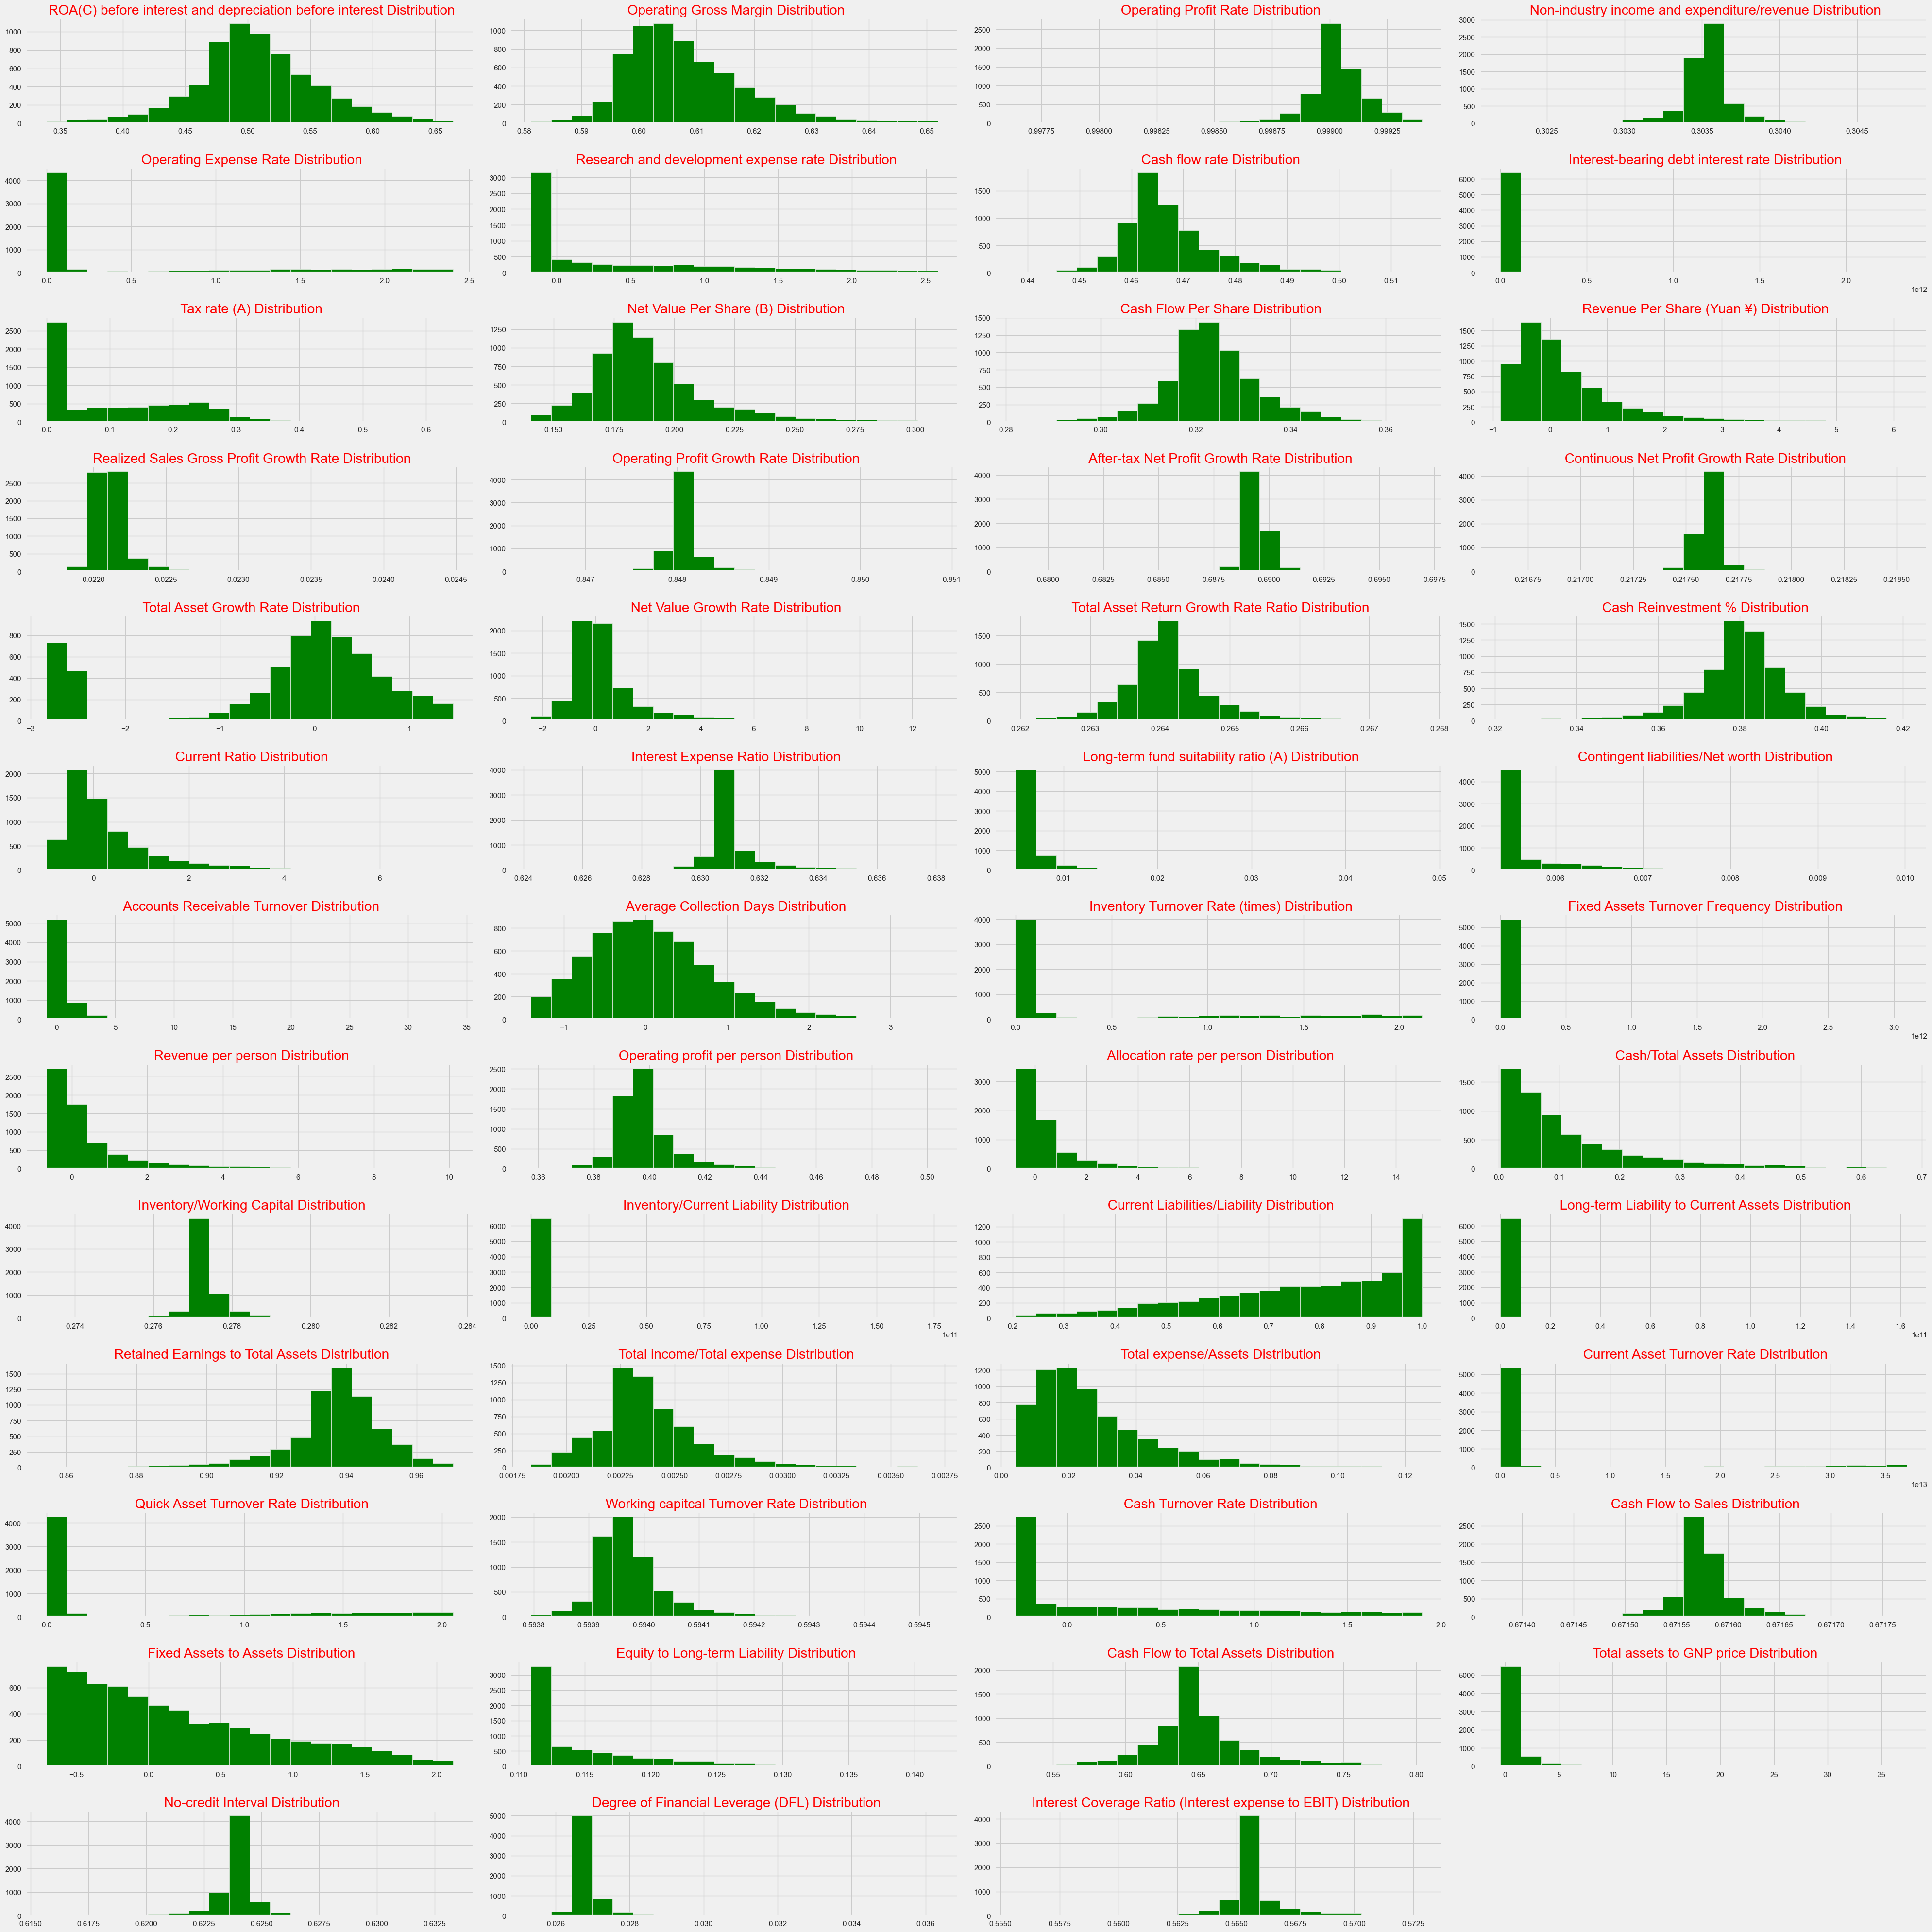

In [54]:
fig=plt.figure(figsize=(40,40))
for i, feature in enumerate(data_univariate):
    ax=fig.add_subplot(13,4,i+1)
    data_univariate[feature].hist(bins=20,ax=ax,facecolor='green')
    ax.set_title(feature+" Distribution",color='red')
    fig.tight_layout()  
plt.show()

In [ ]:
#from histogram we can see that none of the columns is normally distributed

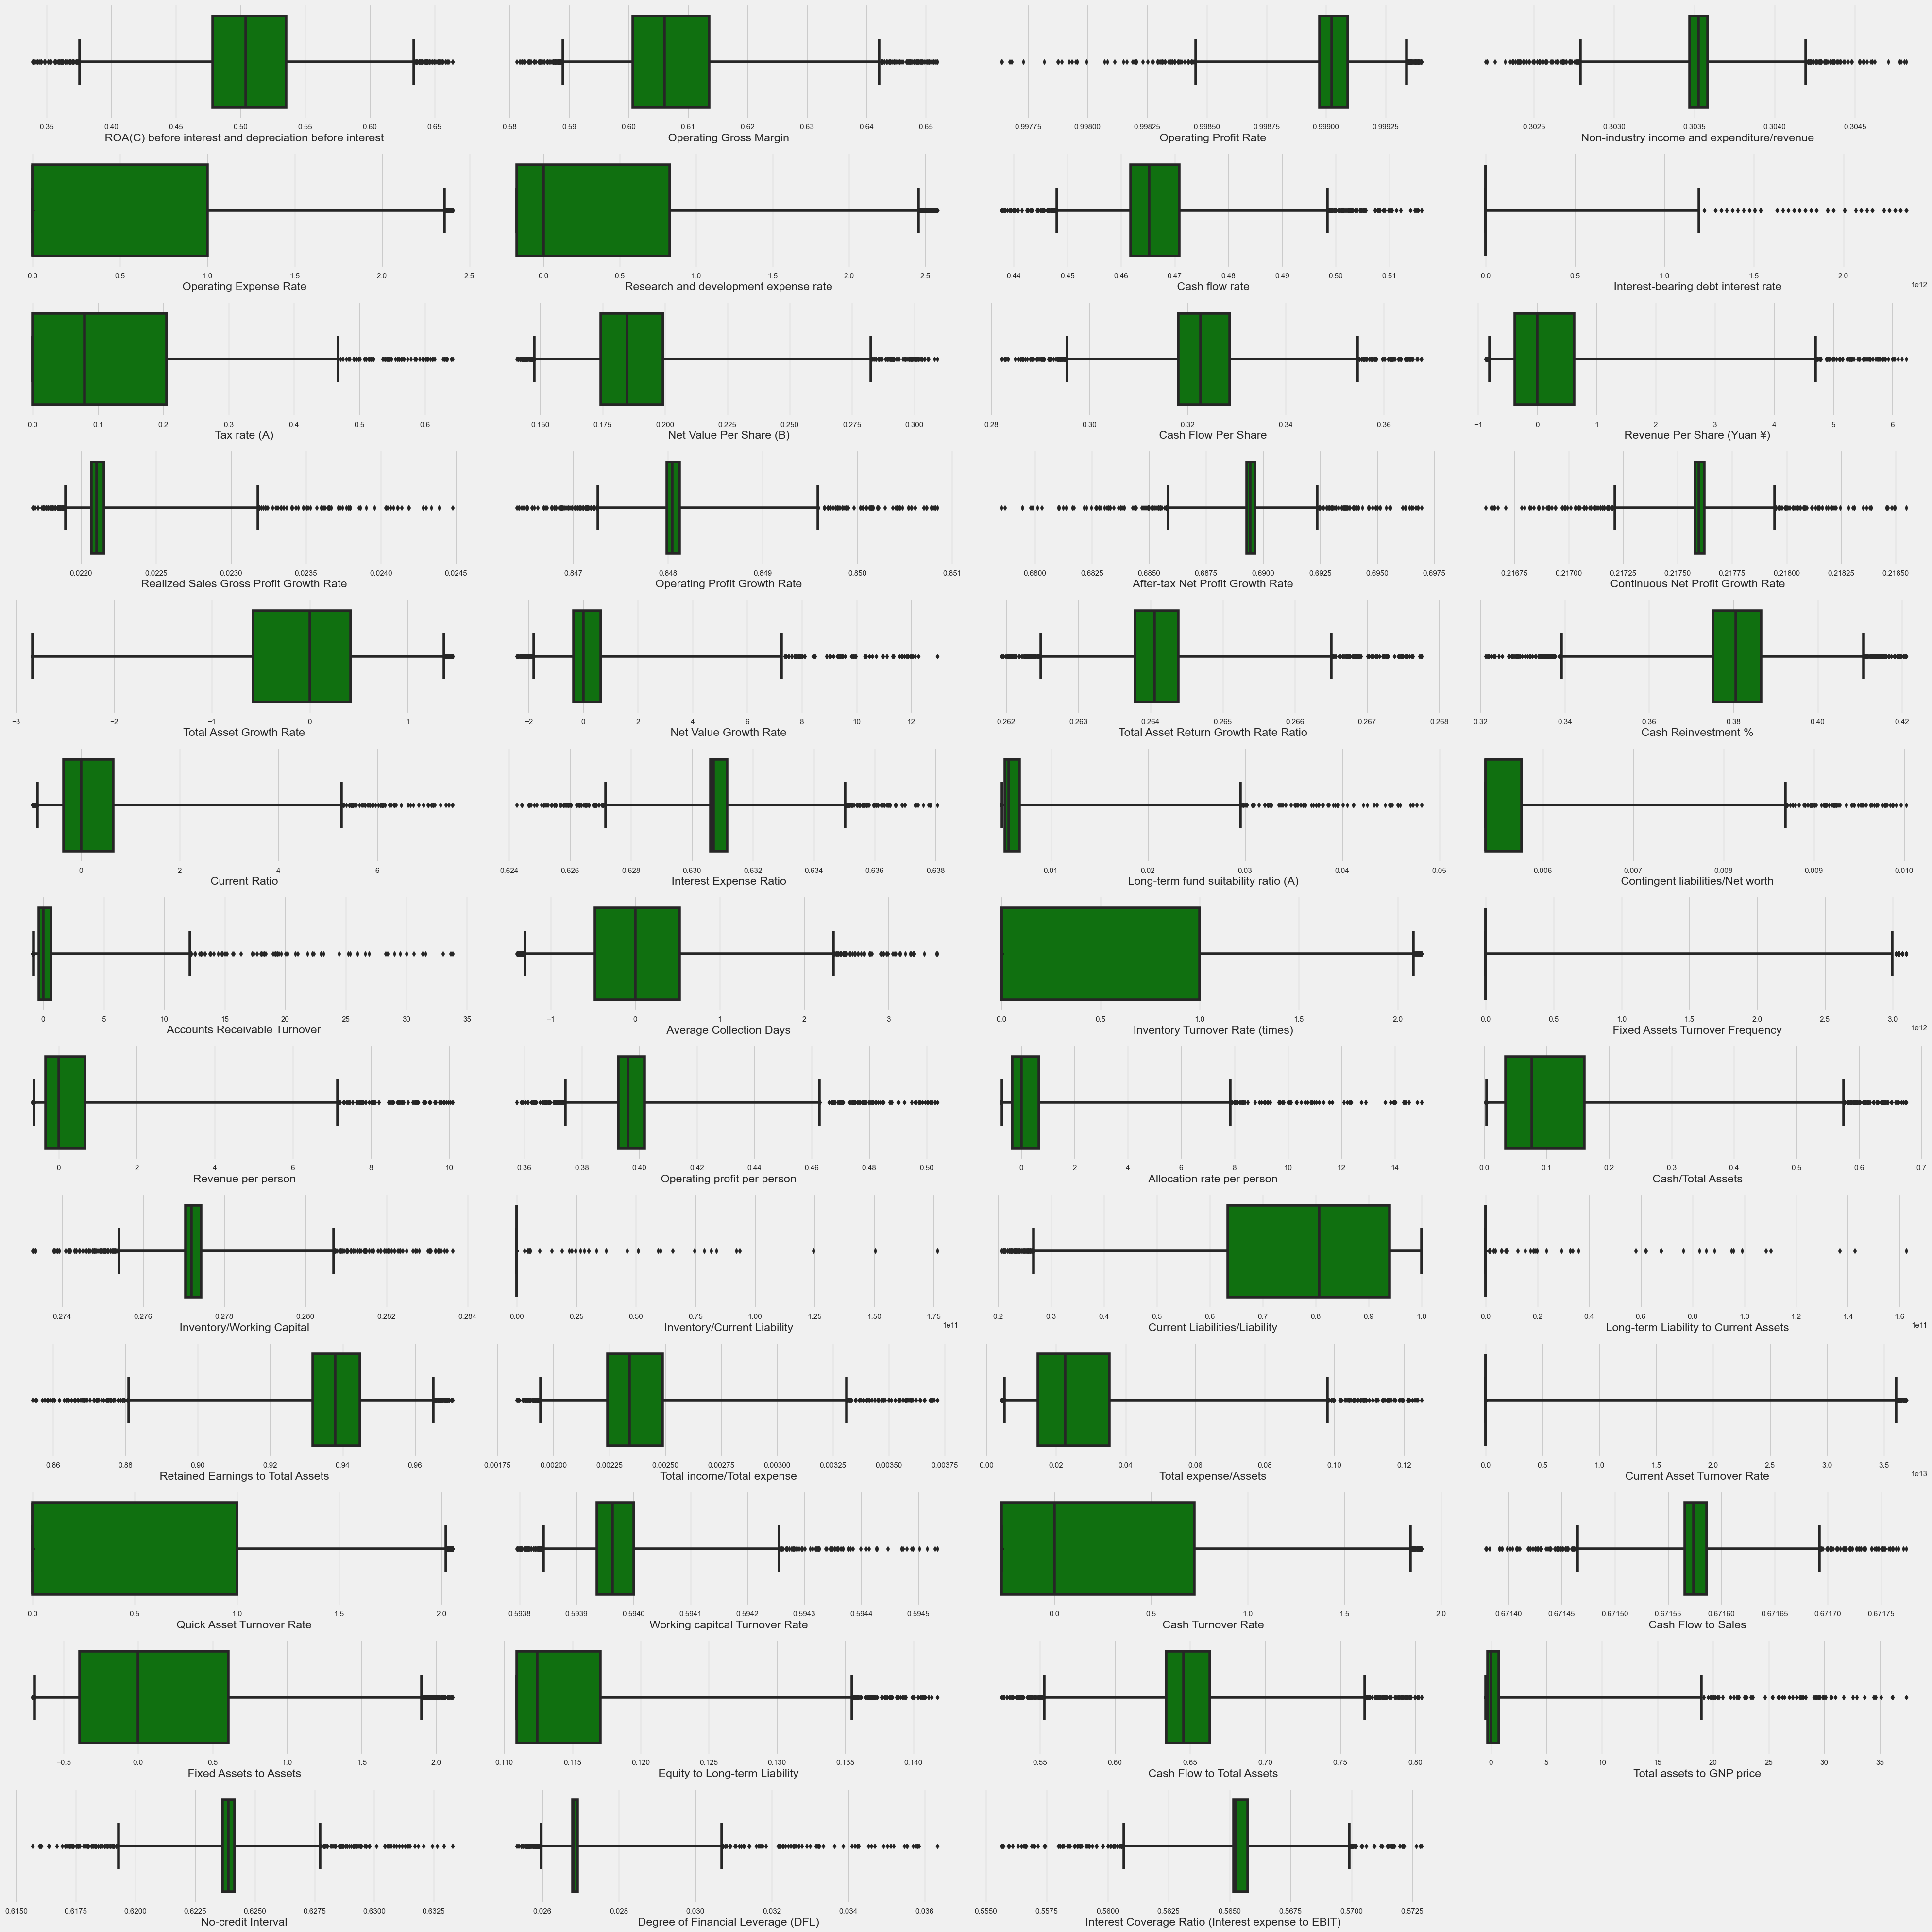

In [57]:
fig=plt.figure(figsize=(40,40))
for i, feature in enumerate(data_univariate):
    ax=fig.add_subplot(13,4,i+1)
    sns.boxplot(data_univariate[feature],whis=(1,99),color = 'green')
    fig.tight_layout()  
plt.show()

In [ ]:
# from the box plots, we can see that there are still outliers
# data is not normally distributed

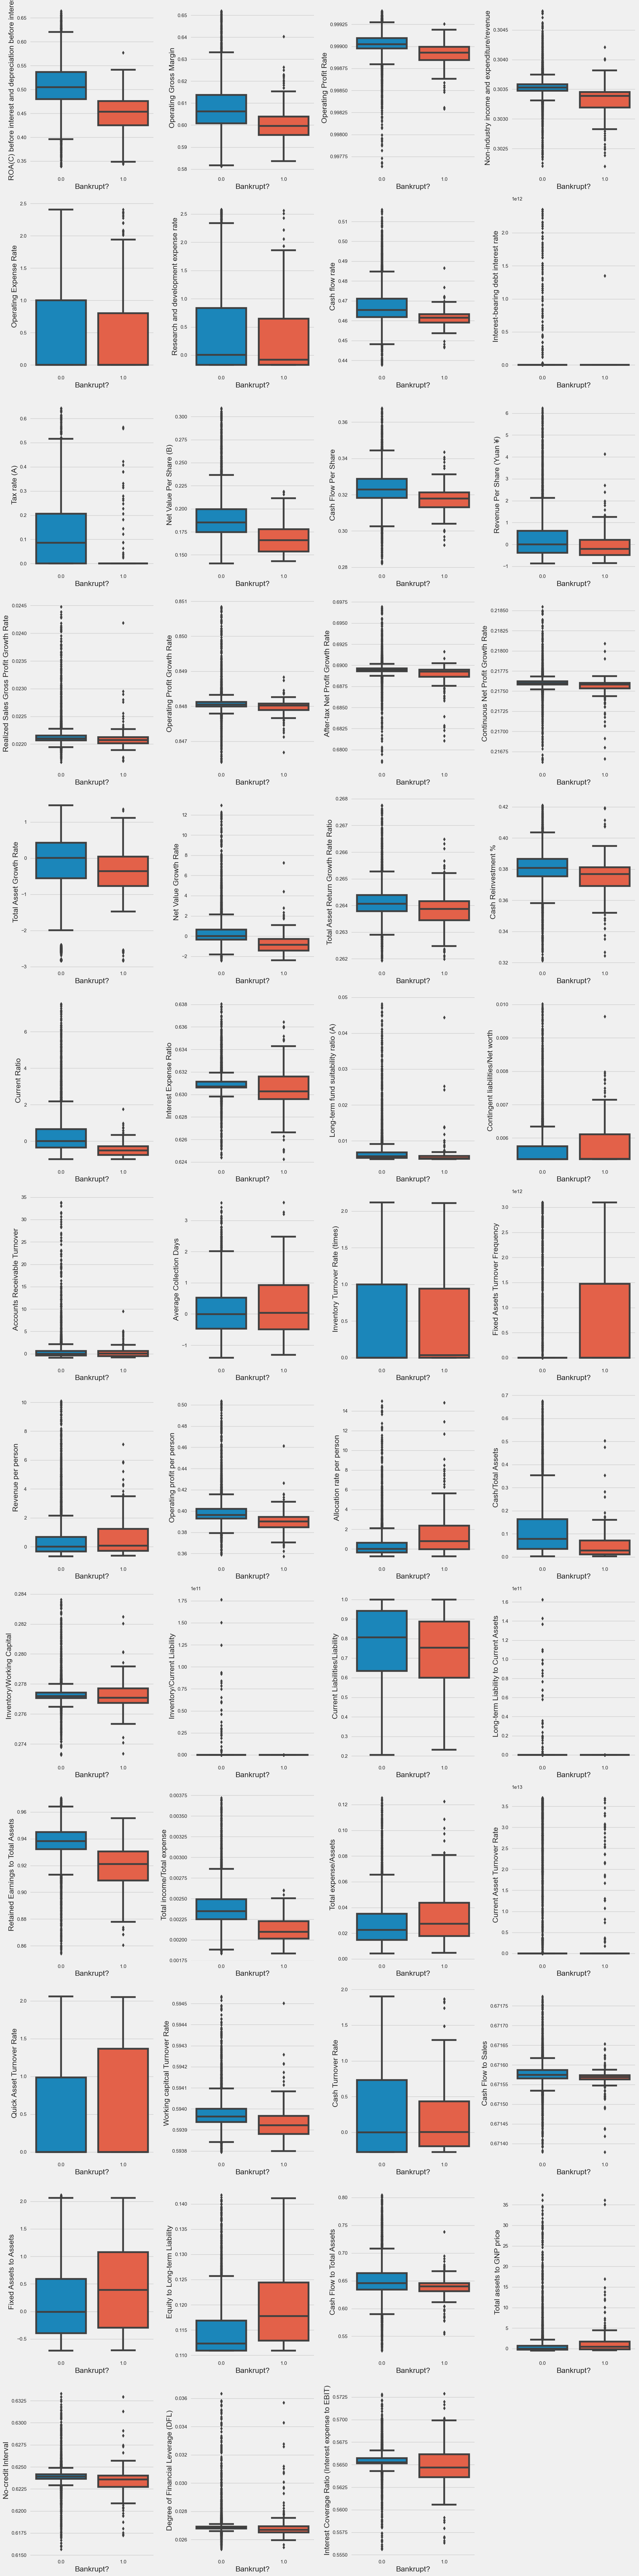

In [61]:
fig=plt.figure(figsize=(20,80))
for i, feature in enumerate(data_scaled):
    if feature != 'Bankrupt?':
        ax=fig.add_subplot(13,4,i)
        sns.boxplot(x = 'Bankrupt?', y = feature, data = data_scaled, ax = ax)
        #ax.set_title(feature,color='red')
        fig.tight_layout()  
plt.show()

In [78]:
#inferences from box plot
#mean of fixed assets to assets is high when company is bankrupt compared when company is not bankrupt
#Mean of ROA(C) is high when company is not bankrupt compared when company is bankrupt
#Mean Revenue per peson is almost equal for companies which are bankrupt and for companies which are not bankrupt
#Mean of Cash Turnover Rate is almost equal for companies which are bankrupt and for companies which are not bankrupt
#Mean of Operating profit rate is greater for companies which are not bankrupt
#Mean of Total Asset Growth Rate is greater for companies which are not bankrupt
#Mean of Allocation rater per person is greater for companies which are bankrupt
#Mean of Operating profit per person is greater for companies which are not bankrupt
#Mean of ratio Total income / total expense is greater for companies which are not bankrupt
#Mean of ratio Total expense/Assets is greater for companies which are bankrupt

# Statistical Tests

In [62]:
df_normal = pd.DataFrame(columns=['Feature','P Value','Inference'])
def updte_normal(feature,p_val,inference):
    global df_normal
    df_normal = df_normal.append({'Feature': feature,'P Value':p_val,'Inference':inference},ignore_index = True)

In [63]:
def hyp_normal(pval):
    if pval > 0.05:
        return 'Data is Normal'
    else:
        return 'Data is not Normal'

In [64]:
for i in data_scaled.columns:
    statistic,pvalue = stats.shapiro(data_scaled[i])
    updte_normal(i,pvalue,hyp_normal(pvalue))

In [65]:
df_normal

Feature       P Value  \
0                                                  Bankrupt?  0.000000e+00   
1    ROA(C) before interest and depreciation before interest  1.022906e-22   
2                                     Operating Gross Margin  1.289195e-43   
3                                      Operating Profit Rate  0.000000e+00   
4                Non-industry income and expenditure/revenue  0.000000e+00   
5                                     Operating Expense Rate  0.000000e+00   
6                      Research and development expense rate  0.000000e+00   
7                                             Cash flow rate  0.000000e+00   
8                        Interest-bearing debt interest rate  0.000000e+00   
9                                               Tax rate (A)  0.000000e+00   
10                                   Net Value Per Share (B)  0.000000e+00   
11                                       Cash Flow Per Share  3.599989e-37   
12                                Revenue Per Share (Yuan ¥)  0.000000e+00   
13                   Realized Sales Gross Profit Growth Rate  0.000000e+00   
14                              Operating Profit Growth Rate  0.000000e+00   
15                          After-tax Net Profit Growth Rate  0.000000e+00   
16                         Continuous Net Profit Growth Rate  0.000000e+00   
17                                   Total Asset Growth Rate  0.000000e+00   
18                                     Net Value Growth Rate  0.000000e+00   
19                      Total Asset Return Growth Rate Ratio  0.000000e+00   
20                                       Cash Reinvestment %  4.077779e-43   
21                                             Current Ratio  0.000000e+00   
22                                    Interest Expense Ratio  0.000000e+00   
23                      Long-term fund suitability ratio (A)  0.000000e+00   
24                          Contingent liabilities/Net worth  0.000000e+00   
25                              Accounts Receivable Turnover  0.000000e+00   
26                                   Average Collection Days  1.269388e-34   
27                           Inventory Turnover Rate (times)  0.000000e+00   
28                           Fixed Assets Turnover Frequency  0.000000e+00   
29                                        Revenue per person  0.000000e+00   
30                               Operating profit per person  0.000000e+00   
31                                Allocation rate per person  0.000000e+00   
32                                         Cash/Total Assets  0.000000e+00   
33                                 Inventory/Working Capital  0.000000e+00   
34                               Inventory/Current Liability  0.000000e+00   
35                             Current Liabilities/Liability  0.000000e+00   
36                     Long-term Liability to Current Assets  0.000000e+00   
37                         Retained Earnings to Total Assets  0.000000e+00   
38                                Total income/Total expense  0.000000e+00   
39                                      Total expense/Assets  0.000000e+00   
40                               Current Asset Turnover Rate  0.000000e+00   
41                                 Quick Asset Turnover Rate  0.000000e+00   
42                            Working capitcal Turnover Rate  0.000000e+00   
43                                        Cash Turnover Rate  0.000000e+00   
44                                        Cash Flow to Sales  0.000000e+00   
45                                    Fixed Assets to Assets  0.000000e+00   
46                             Equity to Long-term Liability  0.000000e+00   
47                                 Cash Flow to Total Assets  0.000000e+00   
48                                 Total assets to GNP price  0.000000e+00   
49                                        No-credit Interval  0.000000e+00   
50                        Degree of Financial Leverage (DFL)  0.000000e+00 

In [66]:
df_inf = pd.DataFrame(columns=['Test_Name','Feature','P-Value','Inference'])

In [67]:
#inference table

def update_inf(test_name,feature,pval,inference):
    global df_inf
    df_inf = df_inf.append({'Test_Name':test_name,
                   'Feature':feature,
                   'P-Value':pval,
                  'Inference':inference} , ignore_index = True)

In [68]:
def hyp(pval):
    if pval > 0.05:
        return 'H0 is selected which means there is no significant difference'
    else:
        return 'H1 is selected which means there is a significant difference'

In [69]:
#as our data is not normal we will use non parametric tests
# for proving the above inferences we will use Man Whittney test

In [70]:
#Hypothesis
#H0:
#there is no significant diff between U(fixed asset to assets for a company which is bankrupt) 
#& U(fixed assets to assets for a company which is not bankrupt)

#H1:
#there is a significant diff between U(fixed asset to assets for a company which is bankrupt) 
#& U(fixed assets to assets for a company which is not bankrupt)

In [71]:
x = data_scaled[data_scaled['Bankrupt?'] == 1][' Fixed Assets to Assets']
y = data_scaled[data_scaled['Bankrupt?'] == 0][' Fixed Assets to Assets']
statistic,p_val = stats.mannwhitneyu(x,y)
#print(hyp(p_val))
update_inf('Mannwhitneyu',' Fixed Assets to Assets',p_val,hyp(p_val))

In [86]:
#Hypothesis
#H0:
#there is no significant diff between U(fixed asset to assets for a company which is bankrupt) 
#& U(cash turnover rate for a company which is not bankrupt)

#H1:
#there is a significant diff between U(fixed asset to assets for a company which is bankrupt) 
#& U(cash turnover rate for a company which is not bankrupt)

In [72]:
x = data_scaled[data_scaled['Bankrupt?'] == 1][' Cash Turnover Rate']
y = data_scaled[data_scaled['Bankrupt?'] == 0][' Cash Turnover Rate']
statistic,p_val = stats.mannwhitneyu(x,y)
update_inf('Mannwhitneyu',' Cash Turnover Rate',p_val,hyp(p_val))

In [88]:
hyp(p_val)

'H0 is selected which means there is no significant difference'

In [89]:
#Hypothesis
#H0:
#there is no significant diff between U(fixed asset to assets for a company which is bankrupt) 
#& U(ROA(C) before interest and depreciation before interest for a company which is not bankrupt)

#H1:
#there is a significant diff between U(fixed asset to assets for a company which is bankrupt) 
#& U(ROA(C) before interest and depreciation before interest for a company which is not bankrupt)

In [73]:
x = data_scaled[data_scaled['Bankrupt?'] == 1][' ROA(C) before interest and depreciation before interest']
y = data_scaled[data_scaled['Bankrupt?'] == 0][' ROA(C) before interest and depreciation before interest']
statistic,p_val = stats.mannwhitneyu(x,y)
update_inf('Mannwhitneyu',' ROA(C) before interest and depreciation before interest',p_val,hyp(p_val))

In [91]:
hyp(p_val)

'H1 is selected which means there is a significant difference'

In [92]:
#' Revenue per person'

In [74]:
x = data_scaled[data_scaled['Bankrupt?'] == 1][' Revenue per person']
y = data_scaled[data_scaled['Bankrupt?'] == 0][' Revenue per person']
statistic,p_val = stats.mannwhitneyu(x,y)
update_inf('Mannwhitneyu',' Revenue per person',p_val,hyp(p_val))
hyp(p_val)

'H0 is selected which means there is no significant difference'

In [94]:
#' Operating Profit Rate'

In [75]:
x = data_scaled[data_scaled['Bankrupt?'] == 1][' Operating Profit Rate']
y = data_scaled[data_scaled['Bankrupt?'] == 0][' Operating Profit Rate']
statistic,p_val = stats.kruskal(x,y)
update_inf('Kruskal-Wallis',' Operating Profit Rate',p_val,hyp(p_val))
hyp(p_val)

'H1 is selected which means there is a significant difference'

In [96]:
#' Total Asset Growth Rate'

In [76]:
x = data_scaled[data_scaled['Bankrupt?'] == 1][' Total Asset Growth Rate']
y = data_scaled[data_scaled['Bankrupt?'] == 0][' Total Asset Growth Rate']
statistic,p_val = stats.kruskal(x,y)
update_inf('Kruskal-Wallis',' Total Asset Growth Rate',p_val,hyp(p_val))
hyp(p_val)

'H1 is selected which means there is a significant difference'

In [98]:
#' Allocation rate per person'

In [77]:
x = data_scaled[data_scaled['Bankrupt?'] == 1][' Allocation rate per person']
y = data_scaled[data_scaled['Bankrupt?'] == 0][' Allocation rate per person']
statistic,p_val = stats.kruskal(x,y)
update_inf('Kruskal-Wallis',' Allocation rate per person',p_val,hyp(p_val))
hyp(p_val)

'H1 is selected which means there is a significant difference'

In [100]:
#' Operating profit per person'

In [78]:
x = data_scaled[data_scaled['Bankrupt?'] == 1][' Operating profit per person']
y = data_scaled[data_scaled['Bankrupt?'] == 0][' Operating profit per person']
statistic,p_val = stats.kruskal(x,y)
update_inf('Kruskal-Wallis',' Operating profit per person',p_val,hyp(p_val))
hyp(p_val)

'H1 is selected which means there is a significant difference'

In [102]:
#' Accounts Receivable Turnover'

In [79]:
x = data_scaled[data_scaled['Bankrupt?'] == 1][' Accounts Receivable Turnover']
y = data_scaled[data_scaled['Bankrupt?'] == 0][' Accounts Receivable Turnover']
statistic,p_val = stats.mannwhitneyu(x,y)
update_inf('Mannwhitneyu',' Accounts Receivable Turnover',p_val,hyp(p_val))
hyp(p_val)

'H0 is selected which means there is no significant difference'

In [104]:
#' Net Value Per Share (B)'

In [80]:
x = data_scaled[data_scaled['Bankrupt?'] == 1][' Net Value Per Share (B)']
y = data_scaled[data_scaled['Bankrupt?'] == 0][' Net Value Per Share (B)']
statistic,p_val = stats.mannwhitneyu(x,y)
update_inf('Mannwhitneyu',' Net Value Per Share (B)',p_val,hyp(p_val))
hyp(p_val)

'H1 is selected which means there is a significant difference'

In [81]:
df_inf

Test_Name                                                   Feature  \
0    Mannwhitneyu                                    Fixed Assets to Assets   
1    Mannwhitneyu                                        Cash Turnover Rate   
2    Mannwhitneyu   ROA(C) before interest and depreciation before interest   
3    Mannwhitneyu                                        Revenue per person   
4  Kruskal-Wallis                                     Operating Profit Rate   
5  Kruskal-Wallis                                   Total Asset Growth Rate   
6  Kruskal-Wallis                                Allocation rate per person   
7  Kruskal-Wallis                               Operating profit per person   
8    Mannwhitneyu                              Accounts Receivable Turnover   
9    Mannwhitneyu                                   Net Value Per Share (B)   

        P-Value                                                      Inference  
0  2.382335e-06   H1 is selected which means there is a significant difference  
1  3.325166e-01  H0 is selected which means there is no significant difference  
2  9.104478e-51   H1 is selected which means there is a significant difference  
3  9.346058e-02  H0 is selected which means there is no significant difference  
4  1.615017e-34   H1 is selected which means there is a significant difference  
5  3.302065e-08   H1 is selected which means there is a significant difference  
6  2.962909e-15   H1 is selected which means there is a significant difference  
7  5.382508e-27   H1 is selected which means there is a significant difference  
8  1.519814e-01  H0 is selected which means there is no significant difference  
9  2.271298e-39   H1 is selected which means there is a significant difference

# Model Building


In [113]:
#downloading the clean data
data_scaled.to_csv('data_final.csv')

In [106]:
x = data_scaled.drop('Bankrupt?',axis =1)
y = data_scaled['Bankrupt?']

In [107]:
xtrain,xtest,ytrain,ytest = train_test_split(x,y,train_size=0.7,random_state=45)

# Link to Google Note Book : https://colab.research.google.com/drive/10O4DuaTyKenyGJlrciVxLE3LMWQ-XOFo#scrollTo=cI8hqGI6MsFB

In [ ]:
#NOTE:
#Threshold values and best models are found from analyzing different Hyper parameters for different models
#analysis can be found in google note book

In [108]:
rfc_5 = RandomForestClassifier(n_estimators = 30,criterion = 'entropy',max_depth = 10, max_features= 40, max_leaf_nodes=24,min_samples_leaf= 5,min_samples_split = 11,class_weight="balanced",ccp_alpha = 0.0001)
gb_1 = GradientBoostingClassifier(init= rfc_5)
gb_1.fit(xtrain,ytrain)

GradientBoostingClassifier(init=RandomForestClassifier(ccp_alpha=0.0001,
                                                       class_weight='balanced',
                                                       criterion='entropy',
                                                       max_depth=10,
                                                       max_features=40,
                                                       max_leaf_nodes=24,
                                                       min_samples_leaf=5,
                                                       min_samples_split=11,
                                                       n_estimators=30))

In [117]:
#for model gb1
def get_train_recall_score(model, X_train_k, X_test_k, y_train_k, y_test_k,threshold =0.191553):
    ypred_train_prob = model.predict_proba(X_train_k)
    ypred_train = [1 if i > threshold else 0 for i in ypred_train_prob[:,1] ]
    return recall_score(y_train_k,ypred_train)
    

def get_test_recall_score(model, X_train_k, X_test_k, y_train_k, y_test_k,threshold = 0.191553):
    ypred_test_prob = model.predict_proba(X_test_k)
    ypred_test = [1 if i > threshold else 0 for i in ypred_test_prob[:,1] ]
    return recall_score(y_test_k,ypred_test)

def get_train_f1_score(model, X_train_k, X_test_k, y_train_k, y_test_k,threshold = 0.191553):
    ypred_train_prob = model.predict_proba(X_train_k)
    ypred_train = [1 if i > threshold else 0 for i in ypred_train_prob[:,1] ]
    return f1_score(y_train_k,ypred_train)

def get_test_f1_score(model, X_train_k, X_test_k, y_train_k, y_test_k,threshold = 0.191553):
    ypred_test_prob = model.predict_proba(X_test_k)
    ypred_test = [1 if i > threshold else 0 for i in ypred_test_prob[:,1] ]
    return f1_score(y_test_k,ypred_test)

def get_train_prec_score(model, X_train_k, X_test_k, y_train_k, y_test_k,threshold = 0.191553):
    ypred_train_prob = model.predict_proba(X_train_k)
    ypred_train = [1 if i > threshold else 0 for i in ypred_train_prob[:,1] ]
    return precision_score(y_train_k,ypred_train)

def get_test_prec_score(model, X_train_k, X_test_k, y_train_k, y_test_k,threshold = 0.191553):
    ypred_test_prob = model.predict_proba(X_test_k)
    ypred_test = [1 if i > threshold else 0 for i in ypred_test_prob[:,1] ]
    return precision_score(y_test_k,ypred_test)

train_recall_scores = []
test_recall_scores = []
train_f1_scores = []
test_f1_scores = []
train_prec_scores = []
test_prec_scores = []
kf = KFold(n_splits = 10)


for train_index, test_index in kf.split(x):
    X_train_k, X_test_k, y_train_k, y_test_k = x.iloc[train_index], x.iloc[test_index], \
                                               y.iloc[train_index], y.iloc[test_index]

    train_recall_scores.append(get_train_recall_score(gb_1, X_train_k, X_test_k, y_train_k, y_test_k)) 
    test_recall_scores.append(get_test_recall_score(gb_1, X_train_k, X_test_k, y_train_k, y_test_k)) 
    train_f1_scores.append(get_train_f1_score(gb_1, X_train_k, X_test_k, y_train_k, y_test_k)) 
    test_f1_scores.append(get_test_f1_score(gb_1, X_train_k, X_test_k, y_train_k, y_test_k))
    train_prec_scores.append(get_train_prec_score(gb_1, X_train_k, X_test_k, y_train_k, y_test_k)) 
    test_prec_scores.append(get_test_prec_score(gb_1, X_train_k, X_test_k, y_train_k, y_test_k))

print('avg train recal',np.mean(train_recall_scores))
print('avg test recal',np.mean(test_recall_scores))
print('avg train f1',np.mean(train_f1_scores))
print('avg test f1',np.mean(test_f1_scores))
print('avg train prec',np.mean(train_prec_scores))
print('avg test prec',np.mean(test_prec_scores))

avg train recal 0.7764969667026842
avg test recal 0.7674250299587884
avg train f1 0.8045738873641625
avg test f1 0.7723183255758445
avg train prec 0.8350612431955551
avg test prec 0.8056628787878786


In [111]:
gb_9 = GradientBoostingClassifier(n_estimators = 2,ccp_alpha = 0.0001,tol = 0.2,max_depth = 16,max_features = 9,max_leaf_nodes = 18,learning_rate= 0.01,min_samples_split = 4,min_samples_leaf = 9,min_weight_fraction_leaf = 0.1,loss = 'deviance',init= rfc_5)
ad3 = AdaBoostClassifier(n_estimators = 1,base_estimator = gb_9,learning_rate= 0.3)
ad3.fit(xtrain,ytrain)

AdaBoostClassifier(base_estimator=GradientBoostingClassifier(ccp_alpha=0.0001,
                                                             init=RandomForestClassifier(ccp_alpha=0.0001,
                                                                                         class_weight='balanced',
                                                                                         criterion='entropy',
                                                                                         max_depth=10,
                                                                                         max_features=40,
                                                                                         max_leaf_nodes=24,
                                                                                         min_samples_leaf=5,
                                                                                         min_samples_split=11,
                                                                                         n_estimators=30),
                                                             learning_rate=0.01,
                                                             loss='deviance',
                                                             max_depth=16,
                                                             max_features=9,
                                                             max_leaf_nodes=18,
                                                             min_samples_leaf=9,
                                                             min_samples_split=4,
                                                             min_weight_fraction_leaf=0.1,
                                                             n_estimators=2,
                                                             tol=0.2),
                   learning_rate=0.3, n_estimators=1)

In [118]:
#for model ad3
def get_train_recall_score(model, X_train_k, X_test_k, y_train_k, y_test_k,threshold =0.481618):
    ypred_train_prob = model.predict_proba(X_train_k)
    ypred_train = [1 if i > threshold else 0 for i in ypred_train_prob[:,1] ]
    return recall_score(y_train_k,ypred_train)
    

def get_test_recall_score(model, X_train_k, X_test_k, y_train_k, y_test_k,threshold = 0.481618):
    ypred_test_prob = model.predict_proba(X_test_k)
    ypred_test = [1 if i > threshold else 0 for i in ypred_test_prob[:,1] ]
    return recall_score(y_test_k,ypred_test)

def get_train_f1_score(model, X_train_k, X_test_k, y_train_k, y_test_k,threshold = 0.481618):
    ypred_train_prob = model.predict_proba(X_train_k)
    ypred_train = [1 if i > threshold else 0 for i in ypred_train_prob[:,1] ]
    return f1_score(y_train_k,ypred_train)

def get_test_f1_score(model, X_train_k, X_test_k, y_train_k, y_test_k,threshold = 0.481618):
    ypred_test_prob = model.predict_proba(X_test_k)
    ypred_test = [1 if i > threshold else 0 for i in ypred_test_prob[:,1] ]
    return f1_score(y_test_k,ypred_test)

def get_train_prec_score(model, X_train_k, X_test_k, y_train_k, y_test_k,threshold = 0.481618):
    ypred_train_prob = model.predict_proba(X_train_k)
    ypred_train = [1 if i > threshold else 0 for i in ypred_train_prob[:,1] ]
    return precision_score(y_train_k,ypred_train)

def get_test_prec_score(model, X_train_k, X_test_k, y_train_k, y_test_k,threshold = 0.481618):
    ypred_test_prob = model.predict_proba(X_test_k)
    ypred_test = [1 if i > threshold else 0 for i in ypred_test_prob[:,1] ]
    return precision_score(y_test_k,ypred_test)

train_recall_scores = []
test_recall_scores = []
train_f1_scores = []
test_f1_scores = []
train_prec_scores = []
test_prec_scores = []
kf = KFold(n_splits = 10)


for train_index, test_index in kf.split(x):
    X_train_k, X_test_k, y_train_k, y_test_k = x.iloc[train_index], x.iloc[test_index], \
                                               y.iloc[train_index], y.iloc[test_index]

    train_recall_scores.append(get_train_recall_score(ad3, X_train_k, X_test_k, y_train_k, y_test_k)) 
    test_recall_scores.append(get_test_recall_score(ad3, X_train_k, X_test_k, y_train_k, y_test_k)) 
    train_f1_scores.append(get_train_f1_score(ad3, X_train_k, X_test_k, y_train_k, y_test_k)) 
    test_f1_scores.append(get_test_f1_score(ad3, X_train_k, X_test_k, y_train_k, y_test_k))
    train_prec_scores.append(get_train_prec_score(ad3, X_train_k, X_test_k, y_train_k, y_test_k)) 
    test_prec_scores.append(get_test_prec_score(ad3, X_train_k, X_test_k, y_train_k, y_test_k))

print('avg train recal',np.mean(train_recall_scores))
print('avg test recal',np.mean(test_recall_scores))
print('avg train f1',np.mean(train_f1_scores))
print('avg test f1',np.mean(test_f1_scores))
print('avg train prec',np.mean(train_prec_scores))
print('avg test prec',np.mean(test_prec_scores))

avg train recal 0.8176683987743261
avg test recal 0.8317115057985276
avg train f1 0.5579024724058849
avg test f1 0.5317306076233512
avg train prec 0.4235605217940043
avg test prec 0.40295828150202173


In [115]:
ad2 = AdaBoostClassifier(n_estimators = 1,base_estimator = gb_9)
ad2.fit(xtrain,ytrain)

AdaBoostClassifier(base_estimator=GradientBoostingClassifier(ccp_alpha=0.0001,
                                                             init=RandomForestClassifier(ccp_alpha=0.0001,
                                                                                         class_weight='balanced',
                                                                                         criterion='entropy',
                                                                                         max_depth=10,
                                                                                         max_features=40,
                                                                                         max_leaf_nodes=24,
                                                                                         min_samples_leaf=5,
                                                                                         min_samples_split=11,
                                                                                         n_estimators=30),
                                                             learning_rate=0.01,
                                                             loss='deviance',
                                                             max_depth=16,
                                                             max_features=9,
                                                             max_leaf_nodes=18,
                                                             min_samples_leaf=9,
                                                             min_samples_split=4,
                                                             min_weight_fraction_leaf=0.1,
                                                             n_estimators=2,
                                                             tol=0.2),
                   n_estimators=1)

In [119]:
#for model ad2
def get_train_recall_score(model, X_train_k, X_test_k, y_train_k, y_test_k,threshold =0.470731):
    ypred_train_prob = model.predict_proba(X_train_k)
    ypred_train = [1 if i > threshold else 0 for i in ypred_train_prob[:,1] ]
    return recall_score(y_train_k,ypred_train)
    

def get_test_recall_score(model, X_train_k, X_test_k, y_train_k, y_test_k,threshold = 0.470731):
    ypred_test_prob = model.predict_proba(X_test_k)
    ypred_test = [1 if i > threshold else 0 for i in ypred_test_prob[:,1] ]
    return recall_score(y_test_k,ypred_test)

def get_train_f1_score(model, X_train_k, X_test_k, y_train_k, y_test_k,threshold = 0.470731):
    ypred_train_prob = model.predict_proba(X_train_k)
    ypred_train = [1 if i > threshold else 0 for i in ypred_train_prob[:,1] ]
    return f1_score(y_train_k,ypred_train)

def get_test_f1_score(model, X_train_k, X_test_k, y_train_k, y_test_k,threshold = 0.470731):
    ypred_test_prob = model.predict_proba(X_test_k)
    ypred_test = [1 if i > threshold else 0 for i in ypred_test_prob[:,1] ]
    return f1_score(y_test_k,ypred_test)

def get_train_prec_score(model, X_train_k, X_test_k, y_train_k, y_test_k,threshold = 0.470731):
    ypred_train_prob = model.predict_proba(X_train_k)
    ypred_train = [1 if i > threshold else 0 for i in ypred_train_prob[:,1] ]
    return precision_score(y_train_k,ypred_train)

def get_test_prec_score(model, X_train_k, X_test_k, y_train_k, y_test_k,threshold = 0.470731):
    ypred_test_prob = model.predict_proba(X_test_k)
    ypred_test = [1 if i > threshold else 0 for i in ypred_test_prob[:,1] ]
    return precision_score(y_test_k,ypred_test)

train_recall_scores = []
test_recall_scores = []
train_f1_scores = []
test_f1_scores = []
train_prec_scores = []
test_prec_scores = []
kf = KFold(n_splits = 10)


for train_index, test_index in kf.split(x):
    X_train_k, X_test_k, y_train_k, y_test_k = x.iloc[train_index], x.iloc[test_index], \
                                               y.iloc[train_index], y.iloc[test_index]

    train_recall_scores.append(get_train_recall_score(ad2, X_train_k, X_test_k, y_train_k, y_test_k)) 
    test_recall_scores.append(get_test_recall_score(ad2, X_train_k, X_test_k, y_train_k, y_test_k)) 
    train_f1_scores.append(get_train_f1_score(ad2, X_train_k, X_test_k, y_train_k, y_test_k)) 
    test_f1_scores.append(get_test_f1_score(ad2, X_train_k, X_test_k, y_train_k, y_test_k))
    train_prec_scores.append(get_train_prec_score(ad2, X_train_k, X_test_k, y_train_k, y_test_k)) 
    test_prec_scores.append(get_test_prec_score(ad2, X_train_k, X_test_k, y_train_k, y_test_k))

print('avg train recal',np.mean(train_recall_scores))
print('avg test recal',np.mean(test_recall_scores))
print('avg train f1',np.mean(train_f1_scores))
print('avg test f1',np.mean(test_f1_scores))
print('avg train prec',np.mean(train_prec_scores))
print('avg test prec',np.mean(test_prec_scores))

avg train recal 0.8356235325505063
avg test recal 0.8434528161261096
avg train f1 0.5853039534512324
avg test f1 0.5578326093680328
avg train prec 0.45059151744199
avg test prec 0.42472362096328825


# SMOTE ANALYSIS

In [86]:
sm = SMOTE()

In [87]:
xresample,yresample = sm.fit_resample(x,y)

In [88]:
xtrain,xtest,ytrain,ytest = train_test_split(xresample,yresample,train_size= 0.7,random_state= 45)

In [89]:
rf = RandomForestClassifier()

In [90]:
rf.fit(xtrain,ytrain)

RandomForestClassifier()

In [ ]:
#Checking for Recall Score after re sampling

In [92]:
np.mean(cross_val_score(rf,xtrain,ytrain,cv = 10,scoring='recall'))

0.9948319645286441

In [93]:
np.mean(cross_val_score(rf,xtest,ytest,cv = 10,scoring='recall'))

0.9900137779002481

# Checking for Accuracy Score after re sampling

In [95]:
np.mean(cross_val_score(rf,xtrain,ytrain,cv = 10,scoring='accuracy'))

0.9816805904879867

In [94]:
np.mean(cross_val_score(rf,xtest,ytest,cv = 10,scoring='accuracy'))

0.96669208888156

# Checking for Precision Score after re sampling

In [96]:
np.mean(cross_val_score(rf,xtrain,ytrain,cv = 10,scoring='precision'))

0.9695915072762877

In [97]:
np.mean(cross_val_score(rf,xtest,ytest,cv = 10,scoring='precision'))

0.9435607710689146

# Checking for F1 Score after re sampling

In [98]:
np.mean(cross_val_score(rf,xtrain,ytrain,cv = 10,scoring='f1'))

0.9816917873812017

In [99]:
np.mean(cross_val_score(rf,xtest,ytest,cv = 10,scoring='f1'))

0.9661474642563734